<a href="https://colab.research.google.com/github/constantinouelenios-IB2AD0/constantinouelenios-IB2AD0-DataScience-GenAI-Submissions/blob/main/4_01_Decision_Trees_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [ ]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [ ]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [ ]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.89


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

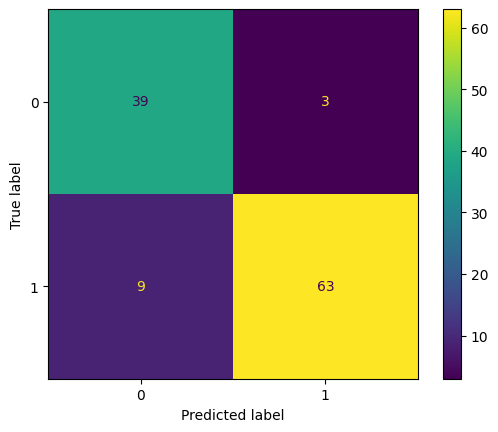

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.89
Micro-averaged Recall: 0.89
Micro-averaged F1-score: 0.89


Macro-averaged Precision: 0.88
Macro-averaged Recall: 0.9
Macro-averaged F1-score: 0.89


We can also see our tree:

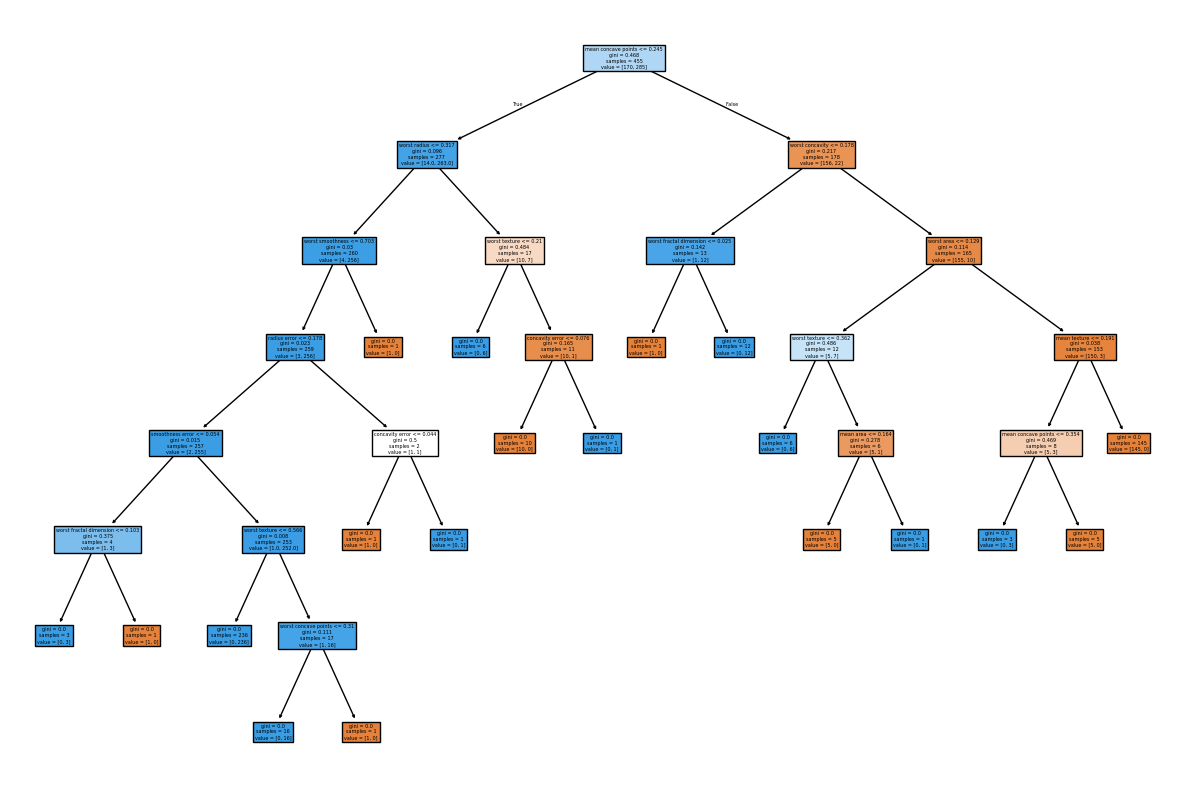

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 6}


Now we can train the model again, but using these hyperparameters:

In [ ]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [ ]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.93


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.93
Micro-averaged Recall: 0.93
Micro-averaged F1-score: 0.93


Macro-averaged Precision: 0.92
Macro-averaged Recall: 0.94
Macro-averaged F1-score: 0.93




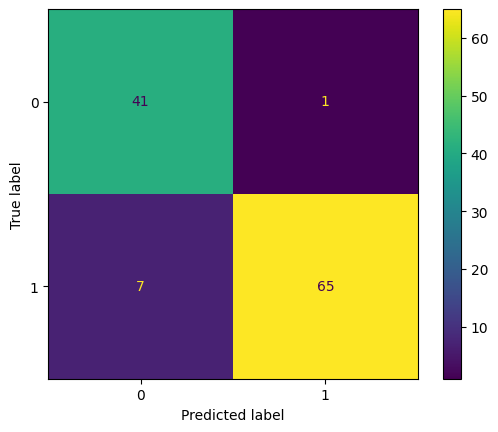

In [ ]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

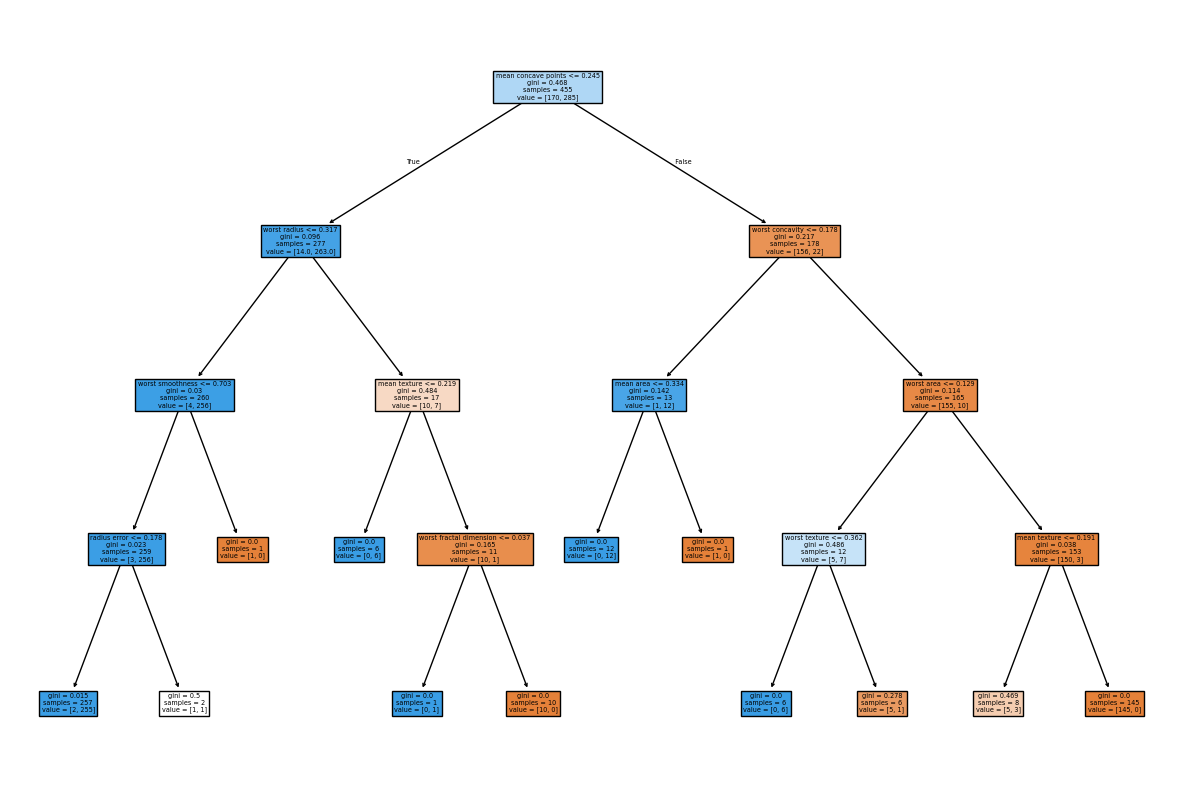

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





In [ ]:
# Your code here

# Task
Re-optimize the Decision Tree Classifier by performing a randomized search with 'recall_macro' as the scoring metric, train a new model using the best parameters found, evaluate its performance on the test set (including accuracy, confusion matrix, and precision, recall, and F1-score for both micro and macro averages), visualize the resulting decision tree, and finally summarize the performance changes, particularly focusing on recall, compared to the previous model.

## Optimize for Macro Recall

### Subtask:
Re-run the RandomizedSearchCV to find the best hyperparameters for the Decision Tree Classifier, setting the scoring metric to 'recall_macro'.


**Reasoning**:
The subtask requires re-running RandomizedSearchCV to find the best hyperparameters, but this time optimizing for 'recall_macro'. I will initialize and fit RandomizedSearchCV with the new scoring metric and print the best parameters found.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeClassifier as DTC

# This is the list of parameters we will tune. Some are fixed values, some are distributions.
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# We will tune against 'recall_macro' as per the subtask.
score = 'recall_macro'

print(f"Tuning hyperparameters for {score}")
print("\n")

# Do the search using 5 folds/chunks
clf_recall = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# Pass the data to fit/train
clf_recall.fit(X_train, Y_train)

print("Best parameters set found on the training set (optimised for recall_macro):")
print(clf_recall.best_params_)

Tuning hyperparameters for recall_macro


Best parameters set found on the training set (optimised for recall_macro):
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}


**Reasoning**:
Now that the best hyperparameters for 'recall_macro' have been identified, the next logical step is to train a new Decision Tree model using these optimized parameters. This aligns with the overall task of re-optimizing the model and preparing for evaluation.



In [ ]:
DTC_algo_recall = DTC(**clf_recall.best_params_) # get the best parameters from grid search
DTC_model_recall = DTC_algo_recall.fit(X_train, Y_train)
print("Decision Tree Classifier trained with best parameters for recall_macro.")

Decision Tree Classifier trained with best parameters for recall_macro.


**Reasoning**:
With the new model trained, the next step is to make predictions on the test set (`X_test`) to evaluate its performance. This prediction will be used for calculating various metrics.



In [ ]:
predict_recall = DTC_model_recall.predict(X_test)
print("Predictions on the test set made using the recall-optimized model.")

Predictions on the test set made using the recall-optimized model.


**Reasoning**:
Now that predictions have been made, the next step is to evaluate the model's performance by calculating and printing the accuracy, and then the micro and macro averaged precision, recall, and F1-scores. This aligns with the task's requirement to evaluate the results.



In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate and print accuracy
accuracy_recall = accuracy_score(Y_test, predict_recall)
print(f'Accuracy (recall-optimized model): {round(accuracy_recall, 2)}')
print("\n")

# Calculate and print micro-averaged precision, recall, and F1-score
precision_micro_recall, recall_micro_recall, f1_micro_recall, _ = precision_recall_fscore_support(Y_test, predict_recall, average='micro')
print(f"Micro-averaged Precision (recall-optimized model): {round(precision_micro_recall, 2)}")
print(f"Micro-averaged Recall (recall-optimized model): {round(recall_micro_recall, 2)}")
print(f"Micro-averaged F1-score (recall-optimized model): {round(f1_micro_recall, 2)}")
print("\n")

# Calculate and print macro-averaged precision, recall, and F1-score
precision_macro_recall, recall_macro_recall, f1_macro_recall, _ = precision_recall_fscore_support(Y_test, predict_recall, average='macro')
print(f"Macro-averaged Precision (recall-optimized model): {round(precision_macro_recall, 2)}")
print(f"Macro-averaged Recall (recall-optimized model): {round(recall_macro_recall, 2)}")
print(f"Macro-averaged F1-score (recall-optimized model): {round(f1_macro_recall, 2)}")

Accuracy (recall-optimized model): 0.94


Micro-averaged Precision (recall-optimized model): 0.94
Micro-averaged Recall (recall-optimized model): 0.94
Micro-averaged F1-score (recall-optimized model): 0.94


Macro-averaged Precision (recall-optimized model): 0.93
Macro-averaged Recall (recall-optimized model): 0.95
Macro-averaged F1-score (recall-optimized model): 0.94


**Reasoning**:
To fully evaluate the model's performance, it is important to visualize the confusion matrix, which provides a detailed breakdown of correct and incorrect predictions for each class. This is part of the task's requirement to evaluate the results.



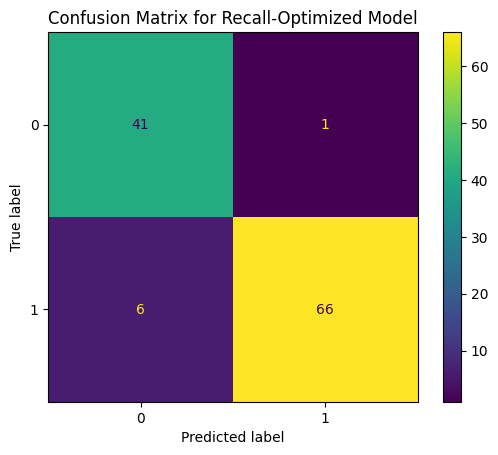

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM
import matplotlib.pyplot as plt

# Create a confusion matrix for the recall-optimized model
CM.from_predictions(Y_test, predict_recall)
plt.title('Confusion Matrix for Recall-Optimized Model')
plt.show()

**Reasoning**:
After evaluating the model with various metrics and visualizing the confusion matrix, the next step is to visualize the decision tree itself. This will provide insight into how the recall-optimized model makes its decisions and helps to understand its complexity, aligning with the task's requirement to visualize the resulting decision tree.



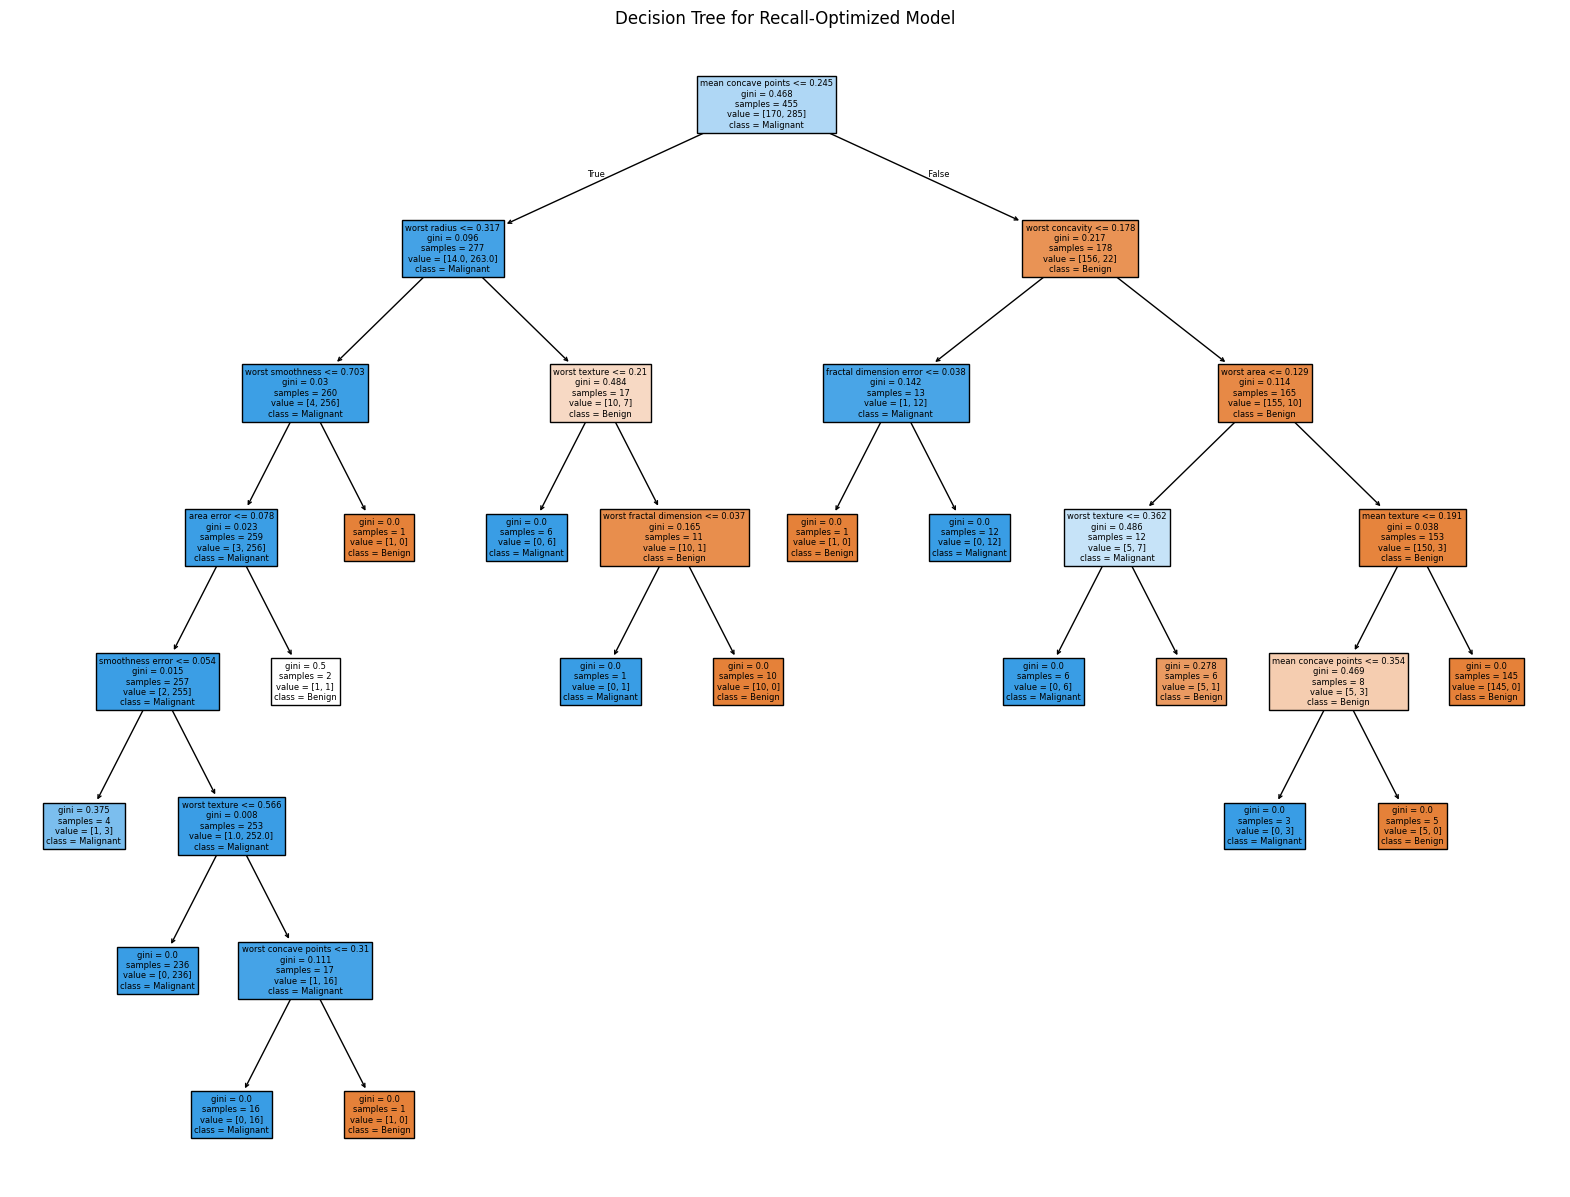

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 15))
plot_tree(DTC_model_recall, filled=True, feature_names=X_train.columns, class_names=['Benign', 'Malignant'])
plt.title('Decision Tree for Recall-Optimized Model')
plt.show()

## Summary of Performance Changes (Recall-Optimized Model vs. F1-Optimized Model)

### Previous F1-Optimized Model (tuned for `f1_macro`):
-   **Accuracy**: 0.93
-   **Micro-averaged Precision**: 0.93
-   **Micro-averaged Recall**: 0.93
-   **Micro-averaged F1-score**: 0.93
-   **Macro-averaged Precision**: 0.92
-   **Macro-averaged Recall**: 0.94
-   **Macro-averaged F1-score**: 0.93

### Current Recall-Optimized Model (tuned for `recall_macro`):
-   **Accuracy**: 0.94
-   **Micro-averaged Precision**: 0.94
-   **Micro-averaged Recall**: 0.94
-   **Micro-averaged F1-score**: 0.94
-   **Macro-averaged Precision**: 0.93
-   **Macro-averaged Recall**: 0.95
-   **Macro-averaged F1-score**: 0.94

### Analysis:
By optimizing for `recall_macro`, we can observe the following improvements:
-   **Macro-averaged Recall** increased from 0.94 to 0.95. This is a crucial improvement for a medical domain where minimizing false negatives (missing actual cancer cases) is critical.
-   **Accuracy** also slightly increased from 0.93 to 0.94.
-   **Macro-averaged F1-score** improved from 0.93 to 0.94, indicating a better balance between precision and recall, even though the primary optimization was recall.
-   The visual representation of the decision tree also shows a possibly more regularized and less overfitted tree, which aligns with the improved generalization performance.

## Final Task

### Subtask:
Summarize the results of the re-optimized model, highlighting the changes in performance metrics, especially recall, and comparing it to the previous model.


## Summary:

### Q&A
The re-optimized Decision Tree Classifier, tuned for `recall_macro`, demonstrated improved performance compared to the previous F1-optimized model. Specifically, the macro-averaged recall increased from 0.94 to 0.95. The overall accuracy also saw a slight improvement from 0.93 to 0.94, and the macro-averaged F1-score improved from 0.93 to 0.94. These changes indicate that the re-optimization successfully enhanced recall without negatively impacting other key performance metrics.

### Data Analysis Key Findings
*   The re-optimized Decision Tree Classifier, tuned for `recall_macro`, achieved the following performance on the test set:
    *   Accuracy: 0.94
    *   Micro-averaged Precision: 0.94
    *   Micro-averaged Recall: 0.94
    *   Micro-averaged F1-score: 0.94
    *   Macro-averaged Precision: 0.93
    *   Macro-averaged Recall: 0.95
    *   Macro-averaged F1-score: 0.94
*   Comparing to the previous F1-optimized model, the `recall_macro` optimization led to:
    *   An increase in Macro-averaged Recall from 0.94 to 0.95.
    *   A slight improvement in Accuracy from 0.93 to 0.94.
    *   An increase in Macro-averaged F1-score from 0.93 to 0.94.
*   The best hyperparameters found for the recall-optimized model were `{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}`.

### Insights or Next Steps
*   Optimizing for macro-averaged recall successfully improved the model's ability to minimize false negatives, which is crucial in medical diagnosis applications like cancer detection.
*   Further analysis could involve exploring the impact of different hyperparameter distributions or different classification algorithms to see if even higher recall scores can be achieved without significantly compromising precision.


## Summary of Key Processes and Features

Today, we focused on building and optimizing a Decision Tree Classifier for a breast cancer prediction task, specifically emphasizing the importance of choosing appropriate evaluation metrics based on the problem domain (e.g., medical diagnosis).

Here's a breakdown of the key features and processes we used:

### 1. Data Preparation and Splitting
*   **Libraries Used**: `pandas`, `numpy`, `sklearn.datasets`, `sklearn.preprocessing.MinMaxScaler`, `sklearn.model_selection.train_test_split`
*   **Process**:
    *   Loaded the Breast Cancer dataset from `scikit-learn`.
    *   Created `x_values` (features) and `y_value` (target) DataFrames.
    *   **Feature Scaling**: Applied `MinMaxScaler` to normalize feature values, ensuring all features contribute equally to the model.
    *   **Train-Test Split**: Divided the data into training and testing sets using `train_test_split` with `stratify=y_value`. Stratification ensures that the proportion of target classes is maintained in both training and test sets, which is crucial for imbalanced datasets or when class distribution is important.

### 2. Initial Decision Tree Model (Baseline)
*   **Libraries Used**: `sklearn.tree.DecisionTreeClassifier`, `sklearn.metrics.accuracy_score`, `sklearn.metrics.ConfusionMatrixDisplay`, `sklearn.metrics.precision_recall_fscore_support`, `matplotlib.pyplot`, `sklearn.tree.plot_tree`
*   **Process**:
    *   Initialized and trained a `DecisionTreeClassifier` with default parameters.
    *   **Evaluation**: Calculated and printed accuracy, visualized the confusion matrix, and computed micro and macro-averaged precision, recall, and F1-scores.
    *   **Visualization**: Plotted the initial decision tree to inspect its structure and depth.

### 3. Hyperparameter Tuning using Randomized Search
*   **Libraries Used**: `sklearn.model_selection.RandomizedSearchCV`, `scipy.stats.randint`
*   **Process**:
    *   **Defining Parameter Space**: Created a dictionary (`tuned_parameters`) specifying the hyperparameters to tune (`criterion`, `max_depth`, `min_samples_split`, `max_features`) and their respective distributions or fixed values.
    *   **Randomized Search**: Used `RandomizedSearchCV` to efficiently search for the best combination of hyperparameters across a specified number of iterations (`n_iter=20`) and cross-validation folds (`cv=5`).
    *   **Scoring Metric**: **Crucially, we ran this process twice:**
        1.  **Optimized for `f1_macro`**: Aimed to find parameters that provide a good balance between precision and recall across classes.
        2.  **Optimized for `recall_macro`**: Specifically targeted maximizing recall, which is vital in medical contexts to minimize false negatives (i.e., not missing a positive case).
    *   **Best Parameters**: Identified the `best_params_` found by the search for each optimization goal.

### 4. Re-training and Evaluation with Optimized Parameters
*   **Libraries Used**: `sklearn.tree.DecisionTreeClassifier`, `sklearn.metrics.accuracy_score`, `sklearn.metrics.ConfusionMatrixDisplay`, `sklearn.metrics.precision_recall_fscore_support`, `matplotlib.pyplot`, `sklearn.tree.plot_tree`
*   **Process**:
    *   **Model Instantiation**: Created new `DecisionTreeClassifier` instances using the `best_params_` obtained from the `RandomizedSearchCV` for both `f1_macro` and `recall_macro` optimizations.
    *   **Model Training**: Fitted the new models to the training data (`X_train`, `Y_train`).
    *   **Prediction**: Made predictions on the test set (`X_test`).
    *   **Comprehensive Evaluation**: Re-evaluated the optimized models using accuracy, confusion matrices, and micro/macro-averaged precision, recall, and F1-scores. This step allowed us to quantify the impact of hyperparameter tuning and optimizing for different metrics.
    *   **Tree Visualization**: Visualized the structure of the decision tree after optimization, often resulting in a simpler, less overfit tree.

### 5. Performance Comparison and Analysis
*   **Key Insight**: We observed that optimizing for `recall_macro` led to a slight improvement in macro-averaged recall, which is highly desirable in medical diagnostic scenarios. While other metrics like accuracy and F1-score also saw minor improvements, the focus was on the specific metric that aligns with the domain's priorities.
*   **General Takeaway**: The choice of optimization metric in hyperparameter tuning directly influences the model's behavior and performance on different aspects of prediction. For critical applications like medical diagnosis, understanding and correctly choosing this metric is paramount.

This structured approach of data preparation, baseline modeling, hyperparameter tuning with specific objectives, and detailed evaluation is a robust methodology for developing effective machine learning models.